# LGBM Model for AWS Spot Price Prediction


AuthorL: Siti Khotijah

Created on: 5/19/2021

# Import libraries

In [1]:
import os
import sys
import time
import random
import logging
import typing as tp
from pathlib import Path
from contextlib import contextmanager
import holidays

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool

%matplotlib inline

# Load Data

In [2]:
# Importing Training Set
import datetime as dt

train=pd.read_csv("../input/flant-processed-data/train_test_train.csv")
train['Timestamp'] = pd.to_datetime(train['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
train['Date']= pd.to_datetime(train['Timestamp']).apply(lambda x: x.date())
train["Date"] = pd.to_datetime(train["Date"], format = '%Y-%m-%d')
train

,AvailabilityZone,InstanceType,Timestamp,Timedel,SpotPrice,Date
0,0,0,2021-02-16 00:00:00+00:00,684.0,0.0671,2021-02-16
1,0,0,2021-02-16 01:00:00+00:00,720.0,0.0671,2021-02-16
2,0,0,2021-02-16 02:00:00+00:00,756.0,0.0671,2021-02-16
3,0,0,2021-02-16 03:00:00+00:00,792.0,0.0671,2021-02-16
4,0,0,2021-02-16 04:00:00+00:00,828.0,0.0671,2021-02-16
...,...,...,...,...,...,...
2289701,5,388,2021-04-09 19:00:00+00:00,46296.0,0.1116,2021-04-09
2289702,5,388,2021-04-09 20:00:00+00:00,46332.0,0.1116,2021-04-09
2289703,5,388,2021-04-09 21:00:00+00:00,46368.0,0.1116,2021-04-09
2289704,5,388,2021-04-09 22:00:00+00:00,46404.0,0.1116,2021-04-09


In [3]:
# Importing testing Set

test = pd.read_csv('../input/flant-processed-data/train_test_test.csv')
test['Timestamp'] = pd.to_datetime(test['Timestamp'], format = '%Y-%m-%d %H:%M:%S.%f')
test['Date']= pd.to_datetime(test['Timestamp']).apply(lambda x: x.date())
test["Date"] = pd.to_datetime(test["Date"], format = '%Y-%m-%d')
test

,AvailabilityZone,InstanceType,Timestamp,Timedel,SpotPrice,Date
0,0,0,2021-04-10 00:00:00+00:00,46476.0,0.0671,2021-04-10
1,0,0,2021-04-10 01:00:00+00:00,46512.0,0.0671,2021-04-10
2,0,0,2021-04-10 02:00:00+00:00,46548.0,0.0671,2021-04-10
3,0,0,2021-04-10 03:00:00+00:00,46584.0,0.0671,2021-04-10
4,0,0,2021-04-10 04:00:00+00:00,46620.0,0.0671,2021-04-10
...,...,...,...,...,...,...
304910,5,388,2021-04-16 17:00:00+00:00,52272.0,0.1116,2021-04-16
304911,5,388,2021-04-16 18:00:00+00:00,52308.0,0.1116,2021-04-16
304912,5,388,2021-04-16 19:00:00+00:00,52344.0,0.1116,2021-04-16
304913,5,388,2021-04-16 20:00:00+00:00,52380.0,0.1116,2021-04-16


In [4]:
def feat_eng(df):
    
    df['Date'] = df['Timestamp'].dt.date
    df['Date'] = pd.to_datetime(df['Date'])

    df['Year'] = df['Timestamp'].dt.year
    df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    df['Day_name'] = df['Timestamp'].dt.day_name()
    df['Hour'] = df['Timestamp'].dt.hour

    # daypart function
    def daypart(hour):
        if hour in [2,3,4,5]:
            return "Dawn"
        elif hour in [6,7,8,9]:
            return "Morning"
        elif hour in [10,11,12,13]:
            return "Noon"
        elif hour in [14,15,16,17]:
            return "Afternoon"
        elif hour in [18,19,20,21]:
            return "Evening"
        else: return "Midnight"
    
    df['Day_parts'] = raw_dayparts = df.Timestamp.dt.hour.apply(daypart)


    df['Weekday'] = df['Timestamp'].dt.weekday
    df['Weekend_YorN'] = ((df['Timestamp'].dt.dayofweek) // 5 == 1).astype(float)
    df['DayofYear'] = df['Timestamp'].dt.dayofyear


    us_holidays = holidays.UnitedStates() 
    hd = []

    # Print all the holidays in UnitedKingdom in year 2018
    for ptr in holidays.US(years = 2021).items():
        #print(ptr)
        hd.append(ptr[0])

    def extractServiceName(x):
        if x in hd:
            return 1
        else:
            return 0

    df['Holiday_YorN'] = df['Date'].apply(lambda x : extractServiceName(x))

  

    df.drop('Timestamp', axis = 1, inplace = True)

    df = df.reset_index(drop = True)

    print (df.shape)
    
    return df

In [5]:
train= feat_eng(train)


(2289706, 15)


In [6]:
test= feat_eng(test)


(304915, 15)


In [7]:
fsub=test.copy()

In [8]:
test= test.drop(['SpotPrice'], axis=1)
test

,AvailabilityZone,InstanceType,Timedel,Date,Year,Month,Day,Day_name,Hour,Day_parts,Weekday,Weekend_YorN,DayofYear,Holiday_YorN
0,0,0,46476.0,2021-04-10,2021,4,10,Saturday,0,Midnight,5,1.0,100,0
1,0,0,46512.0,2021-04-10,2021,4,10,Saturday,1,Midnight,5,1.0,100,0
2,0,0,46548.0,2021-04-10,2021,4,10,Saturday,2,Dawn,5,1.0,100,0
3,0,0,46584.0,2021-04-10,2021,4,10,Saturday,3,Dawn,5,1.0,100,0
4,0,0,46620.0,2021-04-10,2021,4,10,Saturday,4,Dawn,5,1.0,100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304910,5,388,52272.0,2021-04-16,2021,4,16,Friday,17,Afternoon,4,0.0,106,0
304911,5,388,52308.0,2021-04-16,2021,4,16,Friday,18,Evening,4,0.0,106,0
304912,5,388,52344.0,2021-04-16,2021,4,16,Friday,19,Evening,4,0.0,106,0
304913,5,388,52380.0,2021-04-16,2021,4,16,Friday,20,Evening,4,0.0,106,0


In [9]:
## Print the categorical columns
print([c for c in train.columns if (1<train[c].nunique()) & (train[c].dtype != np.number)& (train[c].dtype != int) ])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  


['Date', 'Day_name', 'Day_parts']


In [10]:
cats=['Date', 'Day_name', 'Day_parts']

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelEncoder, OrdinalEncoder
for col in cats:
    print(col)
    train_only = list(set(train[col].unique()) - set(test[col].unique()))
    test_only = list(set(test[col].unique()) - set(train[col].unique()))
    both = list(set(test[col].unique()).union(set(train[col].unique())))
    print(len(both), len(train_only), len(test_only))
    train.loc[train[col].isin(train_only), col] = np.nan
    test.loc[test[col].isin(test_only), col] = np.nan
    try:
        lbl = OrdinalEncoder(dtype='int')
        train[col] = lbl.fit_transform(train[col].astype('str').values.reshape(-1,1))
        train[col] = train[col].astype('category')
        test[col] = lbl.transform(test[col].astype('str').values.reshape(-1,1))
        test[col] = test[col].astype('category')
    except:
        try:
            lbl = LabelEncoder()
            fit_by = pd.Series([i for i in X[col].unique() if type(i) == str])
            lbl.fit(fit_by)
            train[col] = train[col].apply(lambda x: lbl.transform([x])[0] if type(x) == str else x)
            test[col] = test[col].apply(lambda x: lbl.transform([x])[0] if type(x) == str else x)
        except:
            drop_columns.append(col)

Date
60 53 7
Day_name
7 0 0
Day_parts
6 0 0


In [12]:
train.head().T

,0,1,2,3,4
AvailabilityZone,0.0000,0.0000,0.0000,0.0000,0.0000
InstanceType,0.0000,0.0000,0.0000,0.0000,0.0000
Timedel,684.0000,720.0000,756.0000,792.0000,828.0000
SpotPrice,0.0671,0.0671,0.0671,0.0671,0.0671
Date,0.0000,0.0000,0.0000,0.0000,0.0000
Year,2021.0000,2021.0000,2021.0000,2021.0000,2021.0000
Month,2.0000,2.0000,2.0000,2.0000,2.0000
Day,16.0000,16.0000,16.0000,16.0000,16.0000
Day_name,5.0000,5.0000,5.0000,5.0000,5.0000
Hour,0.0000,1.0000,2.0000,3.0000,4.0000


# Definition

In [13]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [14]:
class TreeModel:
    """Wrapper for LightGBM/XGBoost/CATBoost"""
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
        elif self.model_type == "cat":
            self.trn_data = Pool(X_train, label=y_train, group_id=[0] * len(X_train))
            self.val_data =  Pool(X_val, label=y_val, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

# Training & Inference

# Config 

In [15]:
#FEAT_COLS = ['AvailabilityZone', 'InstanceType', 'Timedel','Hour','Day','Month']
FEAT_COLS = ['AvailabilityZone', 'InstanceType', 'Timedel', 'Day', 'Hour', 'Weekend_YorN', 'DayofYear']
TGT_COL = 'SpotPrice'

N_SPLITS = 10
RANDOM_SEED =42 
USE_MODEL = "lgb"

MODEL_PARAMS = {
  
   "seed": RANDOM_SEED,
      "n_jobs": 4,
  'num_leaves': 350,
'max_bin':700,
'min_child_weight': 0.03454472573214212,
'feature_fraction': 0.58,
'bagging_fraction': 0.58,
'max_depth': -1,
'learning_rate': 0.01,
"boosting_type": "gbdt",
"bagging_seed": 11,
"verbosity": -1,
'reg_alpha': 0.3899927210061127,
'reg_lambda': 0.6485237330340494,
 'metric': 'rmse',
  'cat_smooth': 39

}


TRAIN_PARAMS = {
    "num_boost_round": 70000,
    "early_stopping_rounds": 100,
    "verbose_eval": -1,
}

# Prepare Data

In [16]:
train.reset_index(inplace=True)
X = train[FEAT_COLS]
X_test = test[FEAT_COLS]

y = train[TGT_COL].values

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
trn_val_indexs = list(kf.split(X, y))

# Training

In [17]:
oof_pred_arr = np.zeros(len(X))
test_preds_arr = np.zeros((N_SPLITS, len(X_test)))
feature_importances = pd.DataFrame()
score_list = []

In [18]:
for fold, (trn_idx, val_idx) in enumerate(trn_val_indexs):
    print("*" * 100)
    print(f"Fold: {fold}")

    #tips_filtered = tips_df.reindex(columns = filtered_columns).


    
    X_trn = X.loc[trn_idx].reset_index(drop=True)
    X_val = X.loc[val_idx].reset_index(drop=True)
    y_trn = y[trn_idx]
    y_val = y[val_idx]

    model = TreeModel(model_type=USE_MODEL)
    with timer(prefix="Model training"):
        model.train(
            params=MODEL_PARAMS, X_train=X_trn, y_train=y_trn,
            X_val=X_val, y_val=y_val, train_params=TRAIN_PARAMS)
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = model.feature_names_
    fi_tmp["importance"] = model.feature_importances_
    fi_tmp["fold"] = fold
    feature_importances = feature_importances.append(fi_tmp)

    val_pred = model.predict(X_val)
    score = mean_squared_error(y_val, val_pred, squared=False)

    print(f"score: {score:.5f}")
    score_list.append([fold, score])
    oof_pred_arr[val_idx] = val_pred
    test_pred = model.predict(X_test)
    test_preds_arr[fold] = test_pred

****************************************************************************************************
Fold: 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[15322]	training's rmse: 0.0064302	valid_1's rmse: 0.00738821
Model training1338.621[s]
score: 0.00739
****************************************************************************************************
Fold: 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16593]	training's rmse: 0.00569603	valid_1's rmse: 0.00664944
Model training1455.930[s]
score: 0.00665
****************************************************************************************************
Fold: 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[12887]	training's rmse: 0.00711308	valid_1's rmse: 0.00843301
Model training1046.060[s]
score: 0.00843
***********************************************************************

# Check Result

### Score of each fold and oof (Out-Of-Fold)

In [19]:
oof_score = mean_squared_error(y, oof_pred_arr, squared=False)
oof_score1 = mean_absolute_error(y, oof_pred_arr)
oof_score2 = mean_absolute_percentage_error(y, oof_pred_arr)* 100

score_list.append(["oof", oof_score,oof_score1,oof_score2])
pd.DataFrame(
    score_list, columns=["Fold", "RMSE","MAE","MAPE"])

,Fold,RMSE,MAE,MAPE
0,0,0.007388,NaN,NaN
1,1,0.006649,NaN,NaN
2,2,0.008433,NaN,NaN
3,3,0.006896,NaN,NaN
4,4,0.007929,NaN,NaN
5,5,0.007693,NaN,NaN
6,6,0.008655,NaN,NaN
7,7,0.008133,NaN,NaN
8,8,0.007980,NaN,NaN
9,9,0.008712,NaN,NaN


### Feature Importance

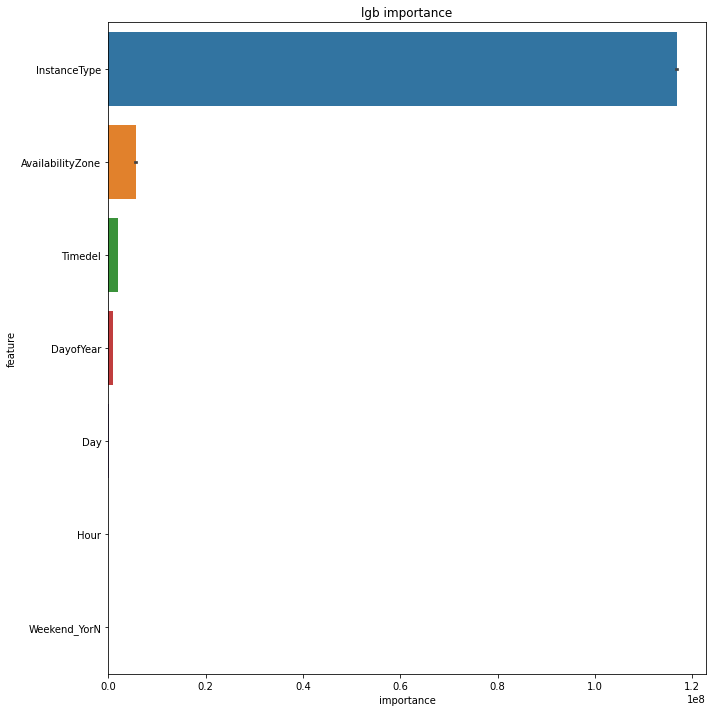

In [20]:
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format(USE_MODEL))
plt.tight_layout()

# Prediction

In [21]:
predictions = pd.DataFrame({'AvailabilityZone':fsub.AvailabilityZone,' InstanceType':fsub.InstanceType,'Timedel':fsub.Timedel,'Real_AWS_SpotPrice':fsub.SpotPrice,'Price_Prediction':test_preds_arr.mean(axis=0)})
predictions.to_csv('Predictions.csv', index=False)
predictions.head(10)

,AvailabilityZone,InstanceType,Timedel,Real_AWS_SpotPrice,Price_Prediction
0,0,0,46476.0,0.0671,0.068101
1,0,0,46512.0,0.0671,0.068337
2,0,0,46548.0,0.0671,0.068311
3,0,0,46584.0,0.0671,0.068455
4,0,0,46620.0,0.0671,0.068285
5,0,0,46656.0,0.0671,0.068152
6,0,0,46692.0,0.0671,0.067848
7,0,0,46728.0,0.0671,0.067784
8,0,0,46764.0,0.0671,0.067716
9,0,0,46800.0,0.0671,0.067515


In [22]:
# https://www.kaggle.com/sumaiaparveenshupti/flant-aws-lstm-final?scriptVersionId=64634178
# Define a function to calculate MAE and RMSE
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

def evaluate_prediction(final_prediction, actual_prediction, model):
    errors = y - oof_pred_arr
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(errors/y).mean() * 100
    #r2 = r2_score(actual_prediction, final_prediction)

    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.4f}'.format(mape))
    #print('R2 Score: {:.4f}'.format(r2))
    print('')
    
evaluate_prediction(predictions['Price_Prediction'], predictions.Real_AWS_SpotPrice, 'LSTM')

Mean Absolute Error: 0.0031
Root Mean Square Error: 0.0079
Mean Absolute Percentage Error: 1.7423



# Plot

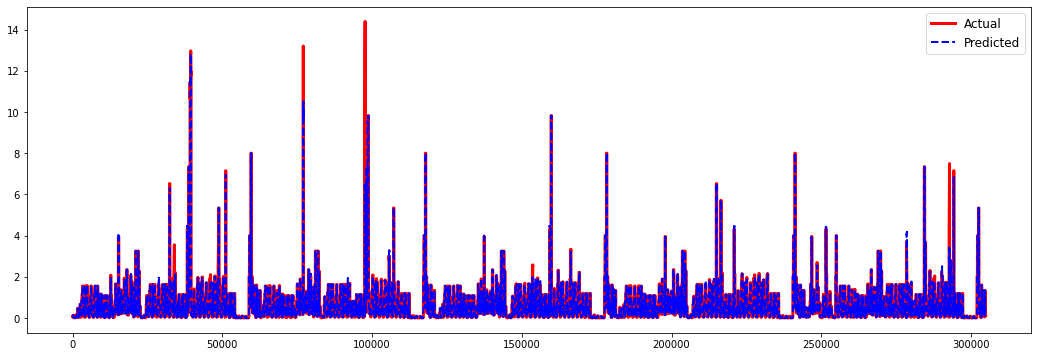

In [23]:
plt.rcParams["figure.figsize"] = [18, 6]

predictions.Real_AWS_SpotPrice.plot(linewidth = 3, label = 'Actual', color = 'red')
predictions.Price_Prediction.plot(linewidth = 2, label = 'Predicted', color = 'blue', linestyle = '--')
plt.legend(fontsize = 'large')

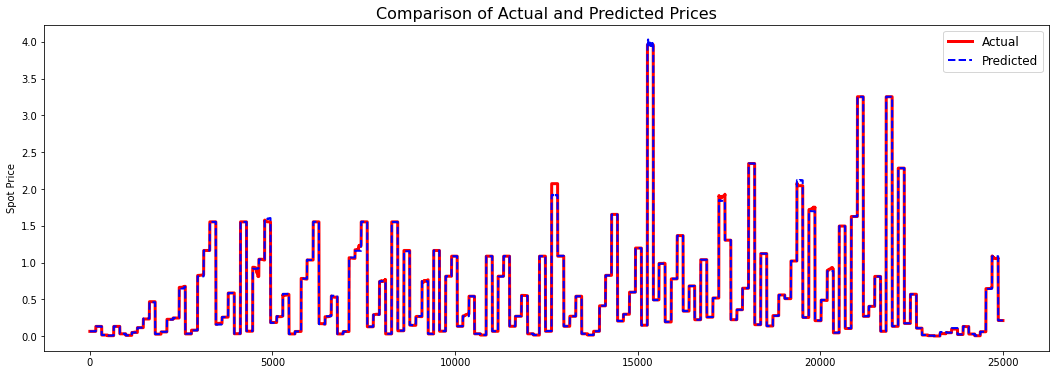

In [24]:
plt.rcParams["figure.figsize"] = [18, 6]
predictions.Real_AWS_SpotPrice[:25000].plot(linewidth = 3, label = 'Actual', color = 'red')
predictions.Price_Prediction[:25000].plot(linewidth = 2, label = 'Predicted', color = 'blue', linestyle = '--')
plt.legend(fontsize = 'large')
plt.ylabel('Spot Price')
plt.title('Comparison of Actual and Predicted Prices', fontsize = 16)
plt.show()

## Make Recomendation

https://www.kaggle.com/ruichongwang/flant-aws-fill-sample-submission

## Load prediction

In [25]:
# you can use your own prediction here
# as long as it contains 
# ['AvailabilityZone', ' InstanceType', 'Timedel', 'Price_Prediction']

import pandas as pd 
prediction_df=predictions.copy()
prediction_df.head()

,AvailabilityZone,InstanceType,Timedel,Real_AWS_SpotPrice,Price_Prediction
0,0,0,46476.0,0.0671,0.068101
1,0,0,46512.0,0.0671,0.068337
2,0,0,46548.0,0.0671,0.068311
3,0,0,46584.0,0.0671,0.068455
4,0,0,46620.0,0.0671,0.068285


## Import recommendation codes

In [26]:
import sys
from os.path import dirname
sys.path.append('../input/flant-aws-recommend')
from flant_aws_recommendation import recommendation

## Get Base Table

In [27]:
%%time
base_df=recommendation(prediction_df)
base_df.recommendation

CPU times: user 6.18 s, sys: 66.9 ms, total: 6.25 s
Wall time: 6.5 s


,cpu,gpu,RAM,2021-04-10 00:00:00+00:00,2021-04-10 01:00:00+00:00,2021-04-10 02:00:00+00:00,2021-04-10 03:00:00+00:00,2021-04-10 04:00:00+00:00,2021-04-10 05:00:00+00:00,2021-04-10 06:00:00+00:00,...,2021-04-16 14:00:00+00:00,2021-04-16 15:00:00+00:00,2021-04-16 16:00:00+00:00,2021-04-16 17:00:00+00:00,2021-04-16 18:00:00+00:00,2021-04-16 19:00:00+00:00,2021-04-16 20:00:00+00:00,2021-04-16 21:00:00+00:00,2021-04-16 22:00:00+00:00,2021-04-16 23:00:00+00:00
tier,,,,,,,,,,,,,,,,,,,,,
2,1,-1,0.613,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1c_t1.micro,us-east-1d_t1.micro,...,us-east-1c_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,us-east-1d_t1.micro,NaN,NaN,NaN
3,1,-1,1.000,us-east-1e_t2.micro,us-east-1e_t2.micro,us-east-1e_t2.micro,us-east-1e_t2.micro,us-east-1e_t2.micro,us-east-1e_t2.micro,us-east-1e_t2.micro,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,-1,1.700,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,...,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,us-east-1d_m1.small,NaN,NaN
5,1,-1,122.000,us-east-1a_f1.2xlarge,us-east-1a_f1.2xlarge,us-east-1a_f1.2xlarge,us-east-1a_f1.2xlarge,us-east-1a_f1.2xlarge,us-east-1a_f1.2xlarge,us-east-1a_f1.2xlarge,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,-1,2.000,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,...,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small,us-east-1e_t2.small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,8,-1,64.000,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,...,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge,us-east-1b_r5b.2xlarge
132,96,-1,192.000,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,...,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5d.metal,us-east-1d_c5.24xlarge,us-east-1d_c5.24xlarge
133,96,-1,384.000,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,...,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1b_m5ad.24xlarge,us-east-1c_m5ad.24xlarge,us-east-1c_m5ad.24xlarge,us-east-1c_m5ad.24xlarge,us-east-1c_m5ad.24xlarge,us-east-1c_m5ad.24xlarge,us-east-1c_m5ad.24xlarge


## Filter Data with Custom Requirement

In [28]:
%%time
# this will return the instance for each tier in each timestamp
# this may return multiple rows, and is difficult to compare the price among tiers
base_df.filter_data(1,1,None,'2021-04-10 22:00:00','2021-04-11 02').filtered_df

CPU times: user 7.31 ms, sys: 0 ns, total: 7.31 ms
Wall time: 6.8 ms


,cpu,gpu,RAM,2021-04-10 22:00:00+00:00,2021-04-10 23:00:00+00:00,2021-04-11 00:00:00+00:00,2021-04-11 01:00:00+00:00,2021-04-11 02:00:00+00:00
tier,,,,,,,,
10,1,1,12.0,us-east-1e_p2.xlarge,us-east-1c_p2.xlarge,us-east-1c_p2.xlarge,us-east-1e_p2.xlarge,us-east-1e_p2.xlarge
11,1,1,16.0,us-east-1d_g4dn.xlarge,us-east-1d_g4dn.xlarge,us-east-1d_g4dn.xlarge,us-east-1d_g4dn.xlarge,us-east-1d_g4dn.xlarge
12,1,1,8.0,us-east-1e_g3s.xlarge,us-east-1e_g3s.xlarge,us-east-1e_g3s.xlarge,us-east-1e_g3s.xlarge,us-east-1e_g3s.xlarge


In [29]:
%%time
# specify var names
base_df.filter_data(cpu=2,start_time='2021-04-10 22:00:00',end_time='2021-04-11 02').filtered_df

CPU times: user 6.8 ms, sys: 0 ns, total: 6.8 ms
Wall time: 6.24 ms


,cpu,gpu,RAM,2021-04-10 22:00:00+00:00,2021-04-10 23:00:00+00:00,2021-04-11 00:00:00+00:00,2021-04-11 01:00:00+00:00,2021-04-11 02:00:00+00:00
tier,,,,,,,,
34,2,-1,0.50,us-east-1f_t4g.nano,us-east-1c_t4g.nano,us-east-1c_t4g.nano,us-east-1f_t4g.nano,us-east-1f_t4g.nano
35,2,-1,1.00,us-east-1f_t4g.micro,us-east-1c_t4g.micro,us-east-1c_t4g.micro,us-east-1f_t4g.micro,us-east-1f_t4g.micro
36,2,-1,1.70,us-east-1a_c1.medium,us-east-1a_c1.medium,us-east-1c_c1.medium,us-east-1c_c1.medium,us-east-1a_c1.medium
37,2,-1,15.25,us-east-1a_r4.large,us-east-1a_r4.large,us-east-1a_r4.large,us-east-1a_r4.large,us-east-1a_r4.large
38,2,-1,16.00,us-east-1d_r5d.large,us-east-1d_r5d.large,us-east-1d_r5d.large,us-east-1d_r5d.large,us-east-1d_r5d.large
39,2,-1,16.00,us-east-1f_r5a.large,us-east-1f_r5a.large,us-east-1f_r5a.large,us-east-1f_r5a.large,us-east-1f_r5a.large
40,2,-1,17.10,us-east-1a_m2.xlarge,us-east-1a_m2.xlarge,us-east-1a_m2.xlarge,us-east-1a_m2.xlarge,us-east-1a_m2.xlarge
41,2,-1,2.00,us-east-1f_t4g.small,us-east-1f_t4g.small,us-east-1c_t4g.small,us-east-1f_t4g.small,us-east-1f_t4g.small
42,2,-1,244.00,us-east-1a_f1.4xlarge,us-east-1a_f1.4xlarge,us-east-1a_f1.4xlarge,us-east-1a_f1.4xlarge,us-east-1a_f1.4xlarge


## Retrive Price For Each Instance

In [30]:
%%time
# this will return the price table based on your last filtering result
base_df.get_price()

CPU times: user 136 ms, sys: 14 ms, total: 150 ms
Wall time: 149 ms


,tier,cpu,gpu,RAM,Timestamp,InstanceType,AvailabilityZone,Price_Prediction
0,34,2,-1,0.5,2021-04-10 22:00:00+00:00,t4g.nano,us-east-1f,0.001614
1,34,2,-1,0.5,2021-04-10 23:00:00+00:00,t4g.nano,us-east-1c,0.001344
2,34,2,-1,0.5,2021-04-11 00:00:00+00:00,t4g.nano,us-east-1c,0.001277
3,34,2,-1,0.5,2021-04-11 01:00:00+00:00,t4g.nano,us-east-1f,0.001377
4,34,2,-1,0.5,2021-04-11 02:00:00+00:00,t4g.nano,us-east-1f,0.001614


## Plotting

In [31]:
%%time
# this will plot the bar chart based on your last filtering result
base_df.plot()

CPU times: user 378 ms, sys: 79.8 ms, total: 458 ms
Wall time: 1.06 s


## In One Line - Get Price Table

In [32]:
%%time
recommendation(prediction_df).filter_data(cpu=2,start_time='2021-04-10 22:00:00',end_time='2021-04-11 02').get_price()

CPU times: user 6.21 s, sys: 63.9 ms, total: 6.28 s
Wall time: 6.28 s


,tier,cpu,gpu,RAM,Timestamp,InstanceType,AvailabilityZone,Price_Prediction
0,34,2,-1,0.5,2021-04-10 22:00:00+00:00,t4g.nano,us-east-1f,0.001614
1,34,2,-1,0.5,2021-04-10 23:00:00+00:00,t4g.nano,us-east-1c,0.001344
2,34,2,-1,0.5,2021-04-11 00:00:00+00:00,t4g.nano,us-east-1c,0.001277
3,34,2,-1,0.5,2021-04-11 01:00:00+00:00,t4g.nano,us-east-1f,0.001377
4,34,2,-1,0.5,2021-04-11 02:00:00+00:00,t4g.nano,us-east-1f,0.001614


## In One Line - Plot

In [33]:
%%time
recommendation(prediction_df).filter_data(start_time='2021-04-10 22:00:00',end_time='2021-04-14 02').plot()

CPU times: user 6.71 s, sys: 75.9 ms, total: 6.78 s
Wall time: 6.8 s


## Optimization

In [34]:
!pip install pulp

     |████████████████████████████████| 40.6 MB 4.1 MB/s 


## Clean Dataframe

In [35]:
import numpy as np 
from pulp import *
import pandas as pd
TEST=False


prediction_df=predictions.copy()
prediction_df.columns=[' AvailabilityZone', ' InstanceType', 'Timedel', 'Real_AWS_SpotPrice','Price_Prediction']

region_label=pd.read_csv('../input/flant-processed-data/region_label_dict.csv')
ins_label=pd.read_csv('../input/flant-processed-data/ins_label_dict.csv')
tier=pd.read_csv('../input/flant-processed-data/tier_df.csv')
time_df=pd.read_csv('../input/flant-processed-data/train_val_test_test.csv',usecols=['Timestamp','Timedel']).drop_duplicates()

prediction_df=ins_label.merge(prediction_df,left_on='InstanceType_label',right_on=' InstanceType').drop(columns=['InstanceType_label',' InstanceType'])
prediction_df=region_label.merge(prediction_df,left_on='AvailabilityZone_label',right_on=' AvailabilityZone').drop(columns=['AvailabilityZone_label',' AvailabilityZone'])
prediction_df=tier.merge(prediction_df,on='InstanceType')
prediction_df=time_df.merge(prediction_df,on='Timedel').drop(columns='Timedel')
prediction_df['gpu']=np.where(prediction_df['gpu']==-1,0,prediction_df['gpu'])
prediction_df['Timestamp']=pd.to_datetime(prediction_df['Timestamp'].transform(lambda x:x.split('+')[0]))
if TEST:
    prediction_df['Price_Prediction']=prediction_df['SpotPrice']
prediction_df=prediction_df[['Timestamp', 'InstanceType','AvailabilityZone', 'cpu', 'gpu', 'RAM', 'Price_Prediction']]

prediction_df

,Timestamp,InstanceType,AvailabilityZone,cpu,gpu,RAM,Price_Prediction
0,2021-04-10 00:00:00,a1.2xlarge,us-east-1a,8,0,16,0.068101
1,2021-04-10 00:00:00,a1.2xlarge,us-east-1c,8,0,16,0.066407
2,2021-04-10 00:00:00,a1.2xlarge,us-east-1d,8,0,16,0.066504
3,2021-04-10 00:00:00,a1.4xlarge,us-east-1a,16,0,32,0.134958
4,2021-04-10 00:00:00,a1.4xlarge,us-east-1c,16,0,32,0.133259
...,...,...,...,...,...,...,...
304910,2021-04-16 23:00:00,r5b.2xlarge,us-east-1a,8,0,64,0.232945
304911,2021-04-16 23:00:00,r5b.2xlarge,us-east-1b,8,0,64,0.173057
304912,2021-04-16 23:00:00,r5b.2xlarge,us-east-1d,8,0,64,0.239645
304913,2021-04-16 23:00:00,r5b.24xlarge,us-east-1b,96,0,768,1.818679


In [36]:
prediction_df.dropna(inplace=True)
prediction_df

,Timestamp,InstanceType,AvailabilityZone,cpu,gpu,RAM,Price_Prediction
0,2021-04-10 00:00:00,a1.2xlarge,us-east-1a,8,0,16,0.068101
1,2021-04-10 00:00:00,a1.2xlarge,us-east-1c,8,0,16,0.066407
2,2021-04-10 00:00:00,a1.2xlarge,us-east-1d,8,0,16,0.066504
3,2021-04-10 00:00:00,a1.4xlarge,us-east-1a,16,0,32,0.134958
4,2021-04-10 00:00:00,a1.4xlarge,us-east-1c,16,0,32,0.133259
...,...,...,...,...,...,...,...
304910,2021-04-16 23:00:00,r5b.2xlarge,us-east-1a,8,0,64,0.232945
304911,2021-04-16 23:00:00,r5b.2xlarge,us-east-1b,8,0,64,0.173057
304912,2021-04-16 23:00:00,r5b.2xlarge,us-east-1d,8,0,64,0.239645
304913,2021-04-16 23:00:00,r5b.24xlarge,us-east-1b,96,0,768,1.818679


 ## Define Function

In [37]:
def optimizer(prediction_df,Min_CPU_num,Min_GPU_num,Min_RAM_Size,Start_Date,End_Date):
    filter_df=prediction_df[(prediction_df.Timestamp>=pd.to_datetime(Start_Date)) & (prediction_df.Timestamp<=pd.to_datetime(End_Date))]
    sample_stamps=filter_df.Timestamp.unique()

    for sample_stamp in sample_stamps:
        sample_df=filter_df[filter_df.Timestamp==sample_stamp]
        sample_df['merge']=sample_df.AvailabilityZone+'_'+sample_df.InstanceType
        sample_df['cpu']=sample_df['cpu'].astype(int)
        sample_df['gpu']=sample_df['gpu'].astype(int)
        sample_df['RAM']=sample_df['RAM'].str.replace(',','').astype(float)
        sample_df.sort_values('merge',inplace=True)

        probA=LpProblem("Problem A",LpMinimize)

        #-----------------------------------------------#
        # Define Parameters and parameter dictionaries  #
        #-----------------------------------------------#
        region_ins=sorted(sample_df['merge'].unique())
        cpus=dict(sample_df[['merge','cpu']].values)
        gpus=dict(sample_df[['merge','gpu']].values)
        rams=dict(sample_df[['merge','RAM']].values)
        prices=dict(sample_df[['merge','Price_Prediction']].values)

        #-----------------------------------#
        #      Define decision variables    #
        #-----------------------------------#
        decisions=LpVariable.dicts("x",region_ins,lowBound=0,cat='Integer')

        #-------------------------------#
        #  Define objective function    #
        #-------------------------------#
        costs = lpSum([decisions[i]*prices[i] for i in region_ins])
        probA+=costs

        #-------------------------------#
        #      Define constraints       #
        #-------------------------------#

        probA+=lpSum([decisions[i]*cpus[i] for i in region_ins]) >= Min_CPU_num,"CPU"
        probA+=lpSum([decisions[i]*gpus[i] for i in region_ins]) >= Min_GPU_num,"GPU"
        probA+=lpSum([decisions[i]*rams[i] for i in region_ins]) >= Min_RAM_Size,"RAM"

        probA.solve()

        output=[]
        for i in region_ins:
            output.append(decisions[i].varValue)

        output_df=pd.DataFrame(output,columns=['Number of Purchase'],index=region_ins)
        output_df=output_df[output_df['Number of Purchase']>0]
        output_df['AvailabilityZone']=list(map(lambda x:x.split('_')[0],output_df.index))
        output_df['InstanceType']=list(map(lambda x:x.split('_')[1],output_df.index))
        output_df.reset_index(inplace=True)
        output_df.columns=['merge','Number of Purchase', 'AvailabilityZone', 'InstanceType']
        output_df=output_df.merge(sample_df[['merge','cpu','gpu','RAM','Price_Prediction']],on='merge').drop(columns='merge')
        output_df=output_df[['AvailabilityZone','InstanceType','Number of Purchase','cpu','gpu','RAM','Price_Prediction']]

        print("Time Stamps: %s\nTotal cost: %.6f\nBest Combination"%(str(sample_stamp)[:19].replace('T',' '),value(probA.objective)))
        display(output_df)

## Customer input

In [38]:
# Customer input
Min_CPU_num=0
Min_GPU_num=0
Min_RAM_Size=18
Start_Date='2021-04-10 22:00:00'
End_Date='2021-04-11 02'

optimizer(prediction_df,Min_CPU_num,Min_GPU_num,Min_RAM_Size,Start_Date,End_Date)

Time Stamps: 2021-04-10 22:00:00
Total cost: 0.025436
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,5.0,1,0,3.75,0.005087


Time Stamps: 2021-04-10 23:00:00
Total cost: 0.025850
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1a,m2.xlarge,1.0,2,0,17.1,0.023896
1,us-east-1e,t2.micro,1.0,1,0,1.0,0.001954


Time Stamps: 2021-04-11 00:00:00
Total cost: 0.025068
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,5.0,1,0,3.75,0.005014


Time Stamps: 2021-04-11 01:00:00
Total cost: 0.025187
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,5.0,1,0,3.75,0.005037


Time Stamps: 2021-04-11 02:00:00
Total cost: 0.025675
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,5.0,1,0,3.75,0.005135


In [39]:
# Customer input
Min_CPU_num=20
Min_GPU_num=0
Min_RAM_Size=180
Start_Date='2021-04-10 22:00:00'
End_Date='2021-04-11 02'

optimizer(prediction_df,Min_CPU_num,Min_GPU_num,Min_RAM_Size,Start_Date,End_Date)

Time Stamps: 2021-04-10 22:00:00
Total cost: 0.244188
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,48.0,1,0,3.75,0.005087


Time Stamps: 2021-04-10 23:00:00
Total cost: 0.249429
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,48.0,1,0,3.75,0.005196


Time Stamps: 2021-04-11 00:00:00
Total cost: 0.240656
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,48.0,1,0,3.75,0.005014


Time Stamps: 2021-04-11 01:00:00
Total cost: 0.241794
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,48.0,1,0,3.75,0.005037


Time Stamps: 2021-04-11 02:00:00
Total cost: 0.246481
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,48.0,1,0,3.75,0.005135


In [40]:
# Customer input
Min_CPU_num=20
Min_GPU_num=0
Min_RAM_Size=1800
Start_Date='2021-04-10 22:00:00'
End_Date='2021-04-11 02'

optimizer(prediction_df,Min_CPU_num,Min_GPU_num,Min_RAM_Size,Start_Date,End_Date)

Time Stamps: 2021-04-10 22:00:00
Total cost: 2.441878
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,480.0,1,0,3.75,0.005087


Time Stamps: 2021-04-10 23:00:00
Total cost: 2.494292
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,480.0,1,0,3.75,0.005196


Time Stamps: 2021-04-11 00:00:00
Total cost: 2.406561
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,480.0,1,0,3.75,0.005014


Time Stamps: 2021-04-11 01:00:00
Total cost: 2.417945
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,480.0,1,0,3.75,0.005037


Time Stamps: 2021-04-11 02:00:00
Total cost: 2.464807
Best Combination


,AvailabilityZone,InstanceType,Number of Purchase,cpu,gpu,RAM,Price_Prediction
0,us-east-1e,m3.medium,480.0,1,0,3.75,0.005135
